In [1]:
from sklearn.cluster import KMeans
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb

import SpatialDE

# =============================================================================
# sc.datasets.visium_sge(sample_id='V1_Breast_Cancer_Block_A_Section_1')
# =============================================================================
plt.rcParams['figure.figsize']=(8,8)
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)
import os,csv,re
import math
from scipy.sparse import issparse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import argparse
from scanpy import read_10x_h5
from sklearn.metrics import pairwise_distances as pair
import scipy.sparse as sp
import h5py
from scipy.sparse import coo_matrix#import squidpy as sq
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
%config InlineBackend.figure_format = 'retina'
#from utils import *
from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csgraph, csr_matrix
from sklearn.metrics import adjusted_rand_score as ari_score
from matplotlib.pyplot import rc_context

-----
anndata     0.9.1
scanpy      1.9.6
-----
PIL                         9.2.0
SpatialDE                   NA
asciitree                   NA
astunparse                  1.6.3
atomicwrites                1.4.0
attr                        21.4.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cupy                        12.2.0
cupy_backends               NA
cupyx                       NA
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        2022.7.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
dill                        0.3.7
entrypoints                 0.4
fasteners                   0.18
fastrlock                   0.8.2
fsspec          

In [2]:
def refine(sample_id, pred, dis, shape="hexagon",neighbor_num=None):
    refined_pred=[]
    pred=pd.DataFrame({"pred": pred}, index=sample_id)
    dis_df=pd.DataFrame(dis, index=sample_id, columns=sample_id)
    if shape=="hexagon":
        num_nbs=6 
    elif shape=="square":
        num_nbs=4
    elif shape=="generic":
        if neighbor_num is None:
            raise ValueError("The parameter cannot be empty, please enter a valid value.")
        else:
            num_nbs=neighbor_num
    else:
        print("Shape not recongized, shape='hexagon' for Visium data, 'square' for ST data.")
    for i in range(len(sample_id)):
        index=sample_id[i]
        dis_tmp=dis_df.loc[index, :].sort_values()
        nbs=dis_tmp[0:num_nbs+1]
        nbs_pred=pred.loc[nbs.index, "pred"]
        self_pred=pred.loc[index, "pred"]
        v_c=nbs_pred.value_counts()
        if (v_c.loc[self_pred]<num_nbs/2) and (np.max(v_c)>num_nbs/2):
            refined_pred.append(v_c.idxmax())
        else:           
            refined_pred.append(self_pred)
    return refined_pred

In [3]:
def set_n_neighbors(platform,n_neighbors):
   
    if n_neighbors is not None:
        return n_neighbors 
        
    if platform == "Visium":
        return 6  
    elif platform == "ST":
        return 4  
    else:
        raise ValueError("Please specify n_neighbors value or use valid platform value, like 'Visium' or 'ST'. ")



In [4]:
def Run_GPCA(adata, location, n_components = 50, method = "knn", platform = "Visium", _lambda = 0.5, n_neighbors=6):
    
    Expr = adata.X
    if issparse(Expr):
        Expr = Expr.todense()
        
    n_neighbors = set_n_neighbors(platform,n_neighbors)
   
    if method=="knn":    
        graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                             metric_params={}, include_self=False)
        graph = 0.5 * (graph + graph.T)
        graphL = csgraph.laplacian(graph,normed=False)
    
    G = scipy.sparse.eye(location.shape[0]) + _lambda * graphL
    if issparse(G):
        Ginv = np.array(np.linalg.inv(G.todense()))
    else:
        Ginv = np.array(np.linalg.inv(G))
    C = np.dot(np.dot(Expr.T,Ginv),Expr)
    lambdas,W = np.linalg.eigh(C)
    W = W[:, ::-1]
    W = W[:, :n_components]
    Z = np.dot(np.dot(Ginv,Expr),W)
    return Z

#### core code

In [5]:
slice_inds = np.arange(0,3)
samples = ["BZ5","BZ9","BZ14"]

In [6]:
Batch_list = []
adj_list = []


for sample_id in slice_inds:
    print(samples[sample_id])
    
    STARmap_expr = pd.read_csv("../../data/STARmap/STARmap_expr_" + samples[sample_id] + ".csv",index_col=0).T
    STARmap_loc = pd.read_csv("../../data/STARmap/STARmap_loc_" + samples[sample_id] + ".csv",index_col=0)
    groundTruth = pd.read_csv("../../data/STARmap/STARmap_groundtruth_" + samples[sample_id] + ".csv",index_col=0)["z"].astype("category")
    adata = ad.AnnData(STARmap_expr)
    adata.obs = STARmap_loc.copy()
    adata.uns["spatial"] = np.array(STARmap_loc)

    adata.obs["groundtruth"] =np.array(groundTruth)-1
    adata.obs["groundtruth"] = adata.obs["groundtruth"].astype(int).astype("category")

    adata.var_names_make_unique()  
    
    # make spot name unique
    adata.obs_names = [x+'_'+ samples[sample_id] for x in adata.obs_names]

    
    ## Constructing the spatial network
    x_array=adata.obs["x"].tolist()
    y_array=adata.obs["y"].tolist()
    X=np.array([x_array, y_array]).T.astype(np.float32)
    n_neighbors = 7
    graph = kneighbors_graph(np.asarray(X), int(n_neighbors), metric='euclidean',
                                     metric_params={}, include_self=False)
    graph = 0.5 * (graph + graph.T)

    adata.uns["adj"] = graph
    adata.obsm["spatial"] = X
    
    # Normalization
    sc.pp.filter_genes(adata, min_cells=20)
    sc.experimental.pp.normalize_pearson_residuals(adata)
    sc.pp.scale(adata)

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

BZ5
computing analytic Pearson residuals on adata.X
    finished (0:00:00)
BZ9
filtered out 7 genes that are detected in less than 20 cells
computing analytic Pearson residuals on adata.X
    finished (0:00:00)
BZ14
filtered out 2 genes that are detected in less than 20 cells
computing analytic Pearson residuals on adata.X
    finished (0:00:00)


In [7]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=samples[slice_inds[0]:slice_inds[-1]+1])
adata_concat.obs['groundtruth'] = adata_concat.obs['groundtruth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (3190, 159)


In [8]:
adj_list

[<1049x1049 sparse matrix of type '<class 'numpy.float64'>'
 	with 8480 stored elements in Compressed Sparse Row format>,
 <1053x1053 sparse matrix of type '<class 'numpy.float64'>'
 	with 8508 stored elements in Compressed Sparse Row format>,
 <1088x1088 sparse matrix of type '<class 'numpy.float64'>'
 	with 8708 stored elements in Compressed Sparse Row format>]

In [9]:
adj_concat = np.asarray(adj_list[0].todense())
for batch_id in range(1,len(samples[slice_inds[0]:slice_inds[-1]+1])):
    adj_concat = scipy.linalg.block_diag(adj_concat, np.asarray(adj_list[batch_id].todense()))
adata_concat.uns['edgeList'] = np.nonzero(adj_concat)
adata_concat.uns['network'] = scipy.sparse.csr_matrix(adj_concat)

In [10]:
adata_concat

AnnData object with n_obs × n_vars = 3190 × 159
    obs: 'x', 'y', 'groundtruth', 'slice_name', 'batch_name'
    uns: 'edgeList', 'network'
    obsm: 'spatial'

In [11]:
adata_concat.uns["edgeList"]

(array([   0,    0,    0, ..., 3189, 3189, 3189], dtype=int64),
 array([   3,    4,    9, ..., 3181, 3182, 3183], dtype=int64))

In [12]:
adata_concat.uns['network']

<3190x3190 sparse matrix of type '<class 'numpy.float64'>'
	with 25696 stored elements in Compressed Sparse Row format>

In [27]:
def UNnormalized_supervised_pca(adata, Y, location, network,n_components=50, method="knn", platform="Visium", _alpha=0.5,_beta=0.5, n_neighbors=6):
    global graphL
    
    Expr = adata.X
    if issparse(Expr):
        Expr = Expr.todense()
    n_neighbors = set_n_neighbors(platform,n_neighbors)
    if network is not None:
        graph = network
    else:
        if method == "knn":
            graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                     metric_params={}, include_self=False)
            graph = 0.5 * (graph + graph.T)
        #graphL = csgraph.laplacian(graph, normed=False)
    Y_YT = sp.csr_matrix(np.dot(Y, Y.T))
    graph = (1 - _beta) * graph + Y_YT * _beta
    graphL = csgraph.laplacian(graph, normed=False)    
    G = sp.eye(adata.obs.shape[0]) + _alpha * graphL
    if issparse(G):
        Ginv = np.array(np.linalg.inv(G.todense()))
    else:
        Ginv = np.array(np.linalg.inv(G))
    C = np.dot(np.dot(Expr.T, Ginv), Expr)
    lambdas, W = np.linalg.eigh(C)
    W = W[:, ::-1]
    W = W[:, :50]
    Z = np.dot(np.dot(Ginv, Expr), W)
    return Z

In [14]:
adata_concat.obs.groundtruth

69x4486_BZ5        0
93x1063_BZ5        0
143x3445_BZ5       0
88x4092_BZ5        0
120x4293_BZ5       0
                  ..
12139x4587_BZ14    3
12214x5199_BZ14    3
12285x3492_BZ14    3
12274x5332_BZ14    3
12271x5994_BZ14    3
Name: groundtruth, Length: 3190, dtype: category
Categories (4, int64): [0, 1, 2, 3]

In [16]:
import os, csv, re
import math
from scipy.sparse import issparse
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

import argparse
from scanpy import read_10x_h5
import squidpy as sq
import scipy.sparse as sp
import h5py
import sys
import tracemalloc
from memory_profiler import memory_usage
from scipy.sparse import coo_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances as pair

def get_onehot_ct(init_assign = None):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(init_assign)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_ct = onehot_encoder.fit_transform(integer_encoded)
    return onehot_ct.astype(np.float32)

In [17]:
Y = get_onehot_ct(adata_concat.obs["groundtruth"])#.astype(np.float32)

In [19]:
for i in range(1049, len(Y)):
    Y[i] = 0

In [44]:
Z = UNnormalized_supervised_pca(adata_concat, Y, location=None,network=adata_concat.uns['network'], 
                                n_components=50, method="knn", platform="Visium", _alpha=0.6,_beta=0.2, n_neighbors=6)

In [368]:
def Run_GPCA(adata, location = None, network = None, n_components = 50, method = "knn", platform = "Visium", _lambda = 0.5, n_neighbors=6):
    Expr = adata.X
    if issparse(Expr):
        Expr = Expr.todense()
        
    if network is not None:
        graph = network
    else:
        if platform=="Visium":
            n_neighbors = 6
        elif platform=="ST":
            n_neighbors = 4
        if method=="knn":    
            graph = kneighbors_graph(np.asarray(location), int(n_neighbors), metric='euclidean',
                                                 metric_params={}, include_self=False)
            graph = 0.5 * (graph + graph.T)
    graphL = csgraph.laplacian(graph,normed=False)
    
    G = scipy.sparse.eye(adata.shape[0]) + _lambda * graphL
    if issparse(G):
        Ginv = np.array(np.linalg.inv(G.todense()))
    else:
        Ginv = np.array(np.linalg.inv(G))
    C = np.dot(np.dot(Expr.T,Ginv),Expr)
    lambdas,W = np.linalg.eigh(C)
    W = W[:, ::-1]
    W = W[:, :n_components]
    Z = np.dot(np.dot(Ginv,Expr),W)
    return Z

In [372]:
Z = Run_GPCA(adata_concat, network=adata_concat.uns['network'], n_components = 50, method = "knn", _lambda = 0.6,n_neighbors=7)


In [68]:
Z = UNnormalized_supervised_pca(adata_concat, Y, location=None,network=adata_concat.uns['network'], 
                                n_components=50, method="knn", platform="Visium", _alpha=0.6,_beta=0.05, n_neighbors=6)

In [69]:
estimator = KMeans(n_clusters=4,random_state=1118)
res = estimator.fit(Z[:,:])
lable_pred=res.labels_
adata_concat.obs["GPCA_pred"]= lable_pred
adata_concat.obs["GPCA_pred"] = adata_concat.obs["GPCA_pred"].astype('category')
adata_concat.obsm["GraphPCA"] = Z

In [70]:
print(ari_score(adata_concat.obs.GPCA_pred,adata_concat.obs.groundtruth))

0.8164087620481248


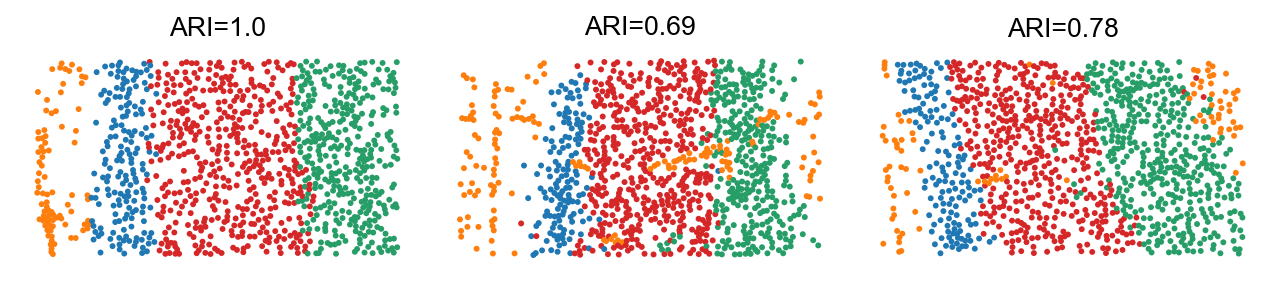

In [71]:
Batch_list = []
for section_id in samples[slice_inds[0]:slice_inds[-1]+1]:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(3):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))

fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)

plt.show()

In [35]:
sc.pp.neighbors(adata_concat, use_rep='GraphPCA', random_state=666)
sc.tl.umap(adata_concat, random_state=666)

section_color = ['#f8766d', '#7cae00', '#00bfc4' ]
section_color_dict = dict(zip(samples[slice_inds[0]:slice_inds[-1]+1], section_color))
adata_concat.uns['batch_name_colors'] = [section_color_dict[x] for x in adata_concat.obs.batch_name.cat.categories]


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


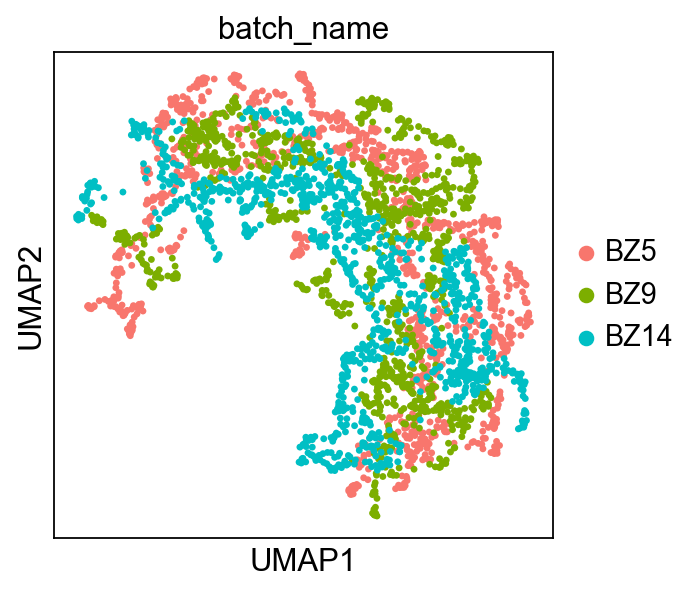

In [297]:
sc.pl.umap(adata_concat, color=['batch_name'], wspace=0.5, show=True,save="batch_GPCA.pdf")

In [378]:
import pandas as pd
import numpy as np
import sklearn.neighbors
import networkx as nx

In [379]:
def match_cluster_labels(true_labels,est_labels):
    true_labels_arr = np.array(list(true_labels))
    est_labels_arr = np.array(list(est_labels))
    org_cat = list(np.sort(list(pd.unique(true_labels))))
    est_cat = list(np.sort(list(pd.unique(est_labels))))
    B = nx.Graph()
    B.add_nodes_from([i+1 for i in range(len(org_cat))], bipartite=0)
    B.add_nodes_from([-j-1 for j in range(len(est_cat))], bipartite=1)
    for i in range(len(org_cat)):
        for j in range(len(est_cat)):
            weight = np.sum((true_labels_arr==org_cat[i])* (est_labels_arr==est_cat[j]))
            B.add_edge(i+1,-j-1, weight=-weight)
    match = nx.algorithms.bipartite.matching.minimum_weight_full_matching(B)
#     match = minimum_weight_full_matching(B)
    if len(org_cat)>=len(est_cat):
        return np.array([match[-est_cat.index(c)-1]-1 for c in est_labels_arr])
    else:
        unmatched = [c for c in est_cat if not (-est_cat.index(c)-1) in match.keys()]
        l = []
        for c in est_labels_arr:
            if (-est_cat.index(c)-1) in match: 
                l.append(match[-est_cat.index(c)-1]-1)
            else:
                l.append(len(org_cat)+unmatched.index(c))
        return np.array(l)

In [380]:
adata_concat.obs['GPCA_pred'] = pd.Series(match_cluster_labels(adata_concat.obs['groundtruth'], adata_concat.obs['GPCA_pred'].values),
                                         index=adata_concat.obs.index, dtype='category')

In [381]:
Ref_colors = ["#E64B35FF","#4DBBD5FF","#00A087FF","#3C5488FF"]
adata_concat.uns['groundtruth_colors'] = Ref_colors
adata_concat.uns['GPCA_pred_colors'] = Ref_colors

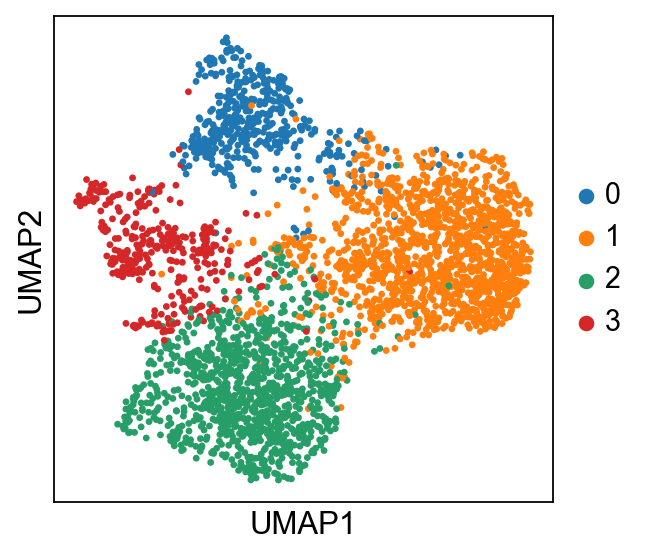

In [42]:
sc.pl.umap(adata_concat, color=['GPCA_pred'], ncols=1, wspace=0.5, show=True,title="")

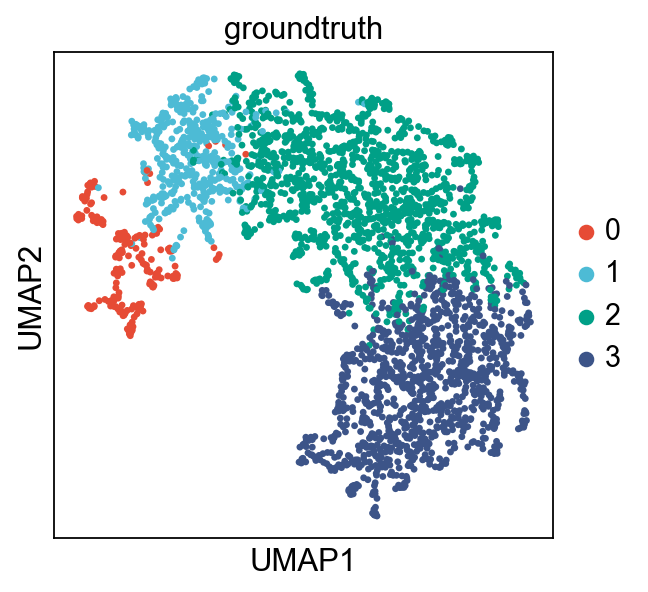

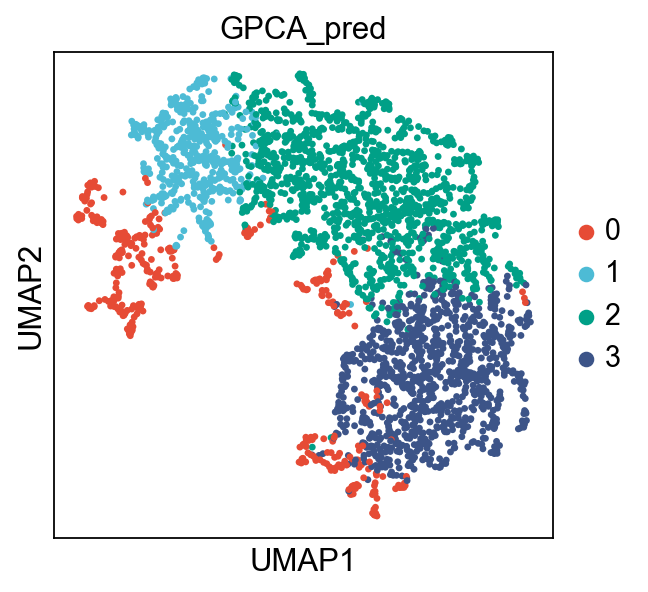

In [383]:
sc.pl.umap(adata_concat, color=[ 'groundtruth'], show=True,save="groundtruth_GPCA.pdf")
sc.pl.umap(adata_concat, color=[ 'GPCA_pred'], show=True,save="GPCA.pdf")

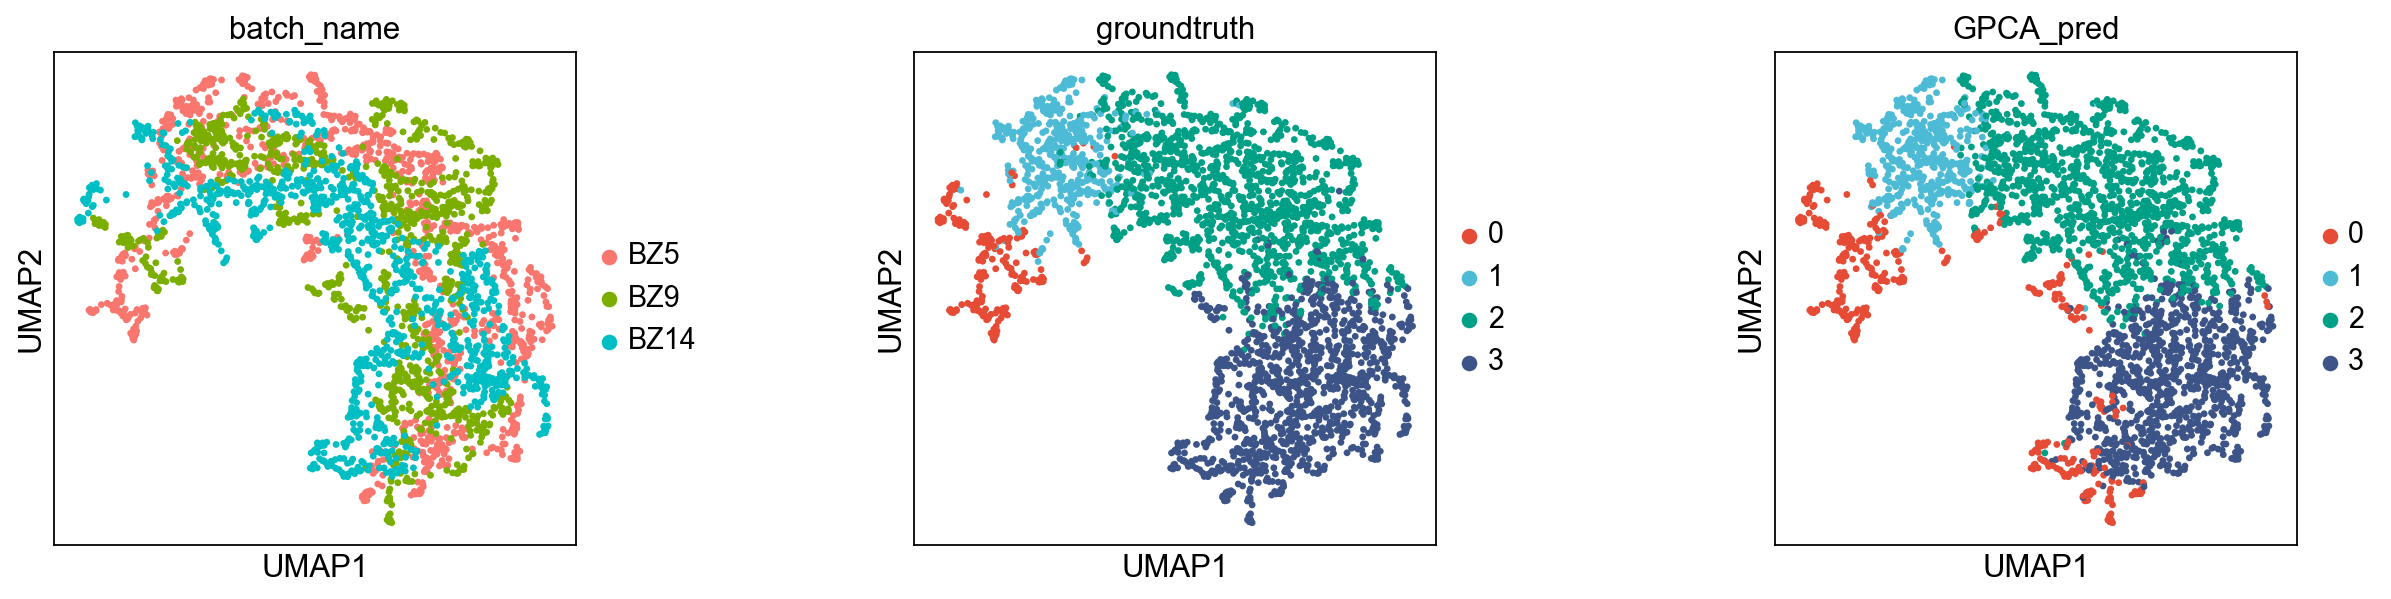

In [384]:
sc.pl.umap(adata_concat, color=['batch_name', 'groundtruth', 'GPCA_pred'], ncols=3, wspace=0.5, show=True)

In [405]:
adata_concat

AnnData object with n_obs × n_vars = 3190 × 159
    obs: 'x', 'y', 'groundtruth', 'slice_name', 'batch_name', 'GPCA_pred'
    uns: 'edgeList', 'network', 'neighbors', 'umap', 'batch_name_colors', 'groundtruth_colors', 'GPCA_pred_colors', 'paga', 'GPCA_pred_sizes', 'groundtruth_sizes'
    obsm: 'spatial', 'GraphPCA', 'X_umap'
    obsp: 'distances', 'connectivities'

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


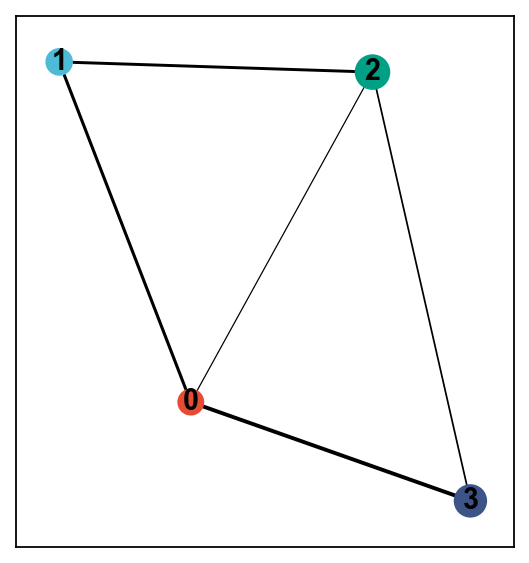

In [403]:
sc.tl.paga(adata_concat, groups='GPCA_pred')
sc.pl.paga(adata_concat, color='GPCA_pred')

In [37]:
adata_concat

AnnData object with n_obs × n_vars = 3190 × 159
    obs: 'x', 'y', 'groundtruth', 'slice_name', 'batch_name', 'GPCA_pred'
    uns: 'edgeList', 'network', 'neighbors', 'umap', 'batch_name_colors', 'GPCA_pred_colors'
    obsm: 'spatial', 'GraphPCA', 'X_umap'
    obsp: 'distances', 'connectivities'

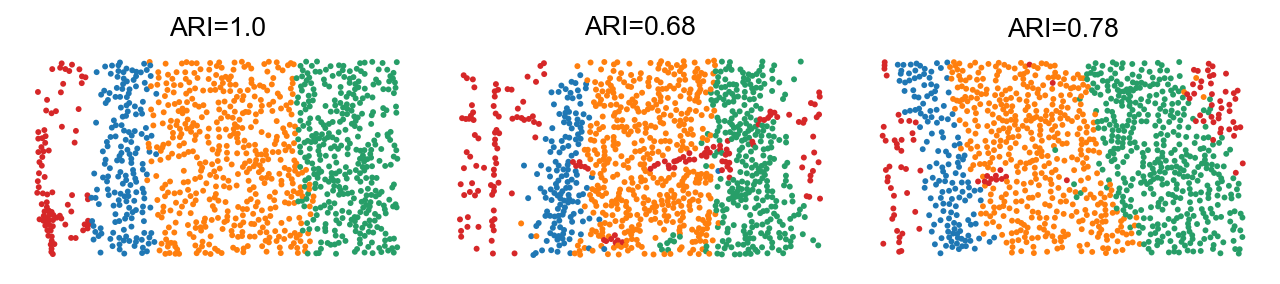

In [43]:
Batch_list = []
for section_id in samples[slice_inds[0]:slice_inds[-1]+1]:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(3):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))

fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)

plt.show()

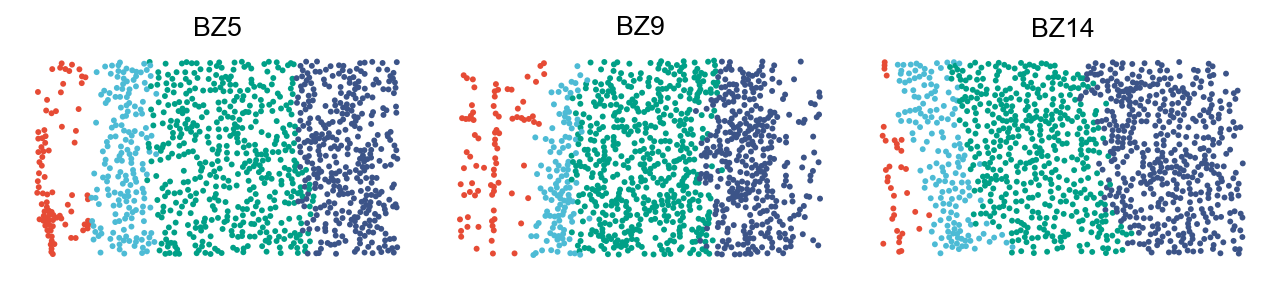

In [295]:
Ref_colors = ["#E64B35FF","#4DBBD5FF","#00A087FF","#3C5488FF"]
Batch_list = []
for section_id in samples[slice_inds[0]:slice_inds[-1]+1]:
    Batch_list.append(adata_concat[adata_concat.obs['batch_name'] == section_id])

import matplotlib.pyplot as plt
spot_size = 200
title_size = 12
ARI_list = []
for bb in range(3):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))
    Batch_list[bb].uns['groundtruth_colors'] = Ref_colors
    
fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['groundtruth'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("BZ5", size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['groundtruth'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("BZ9", size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['groundtruth'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("BZ14", size=title_size)

plt.show()

In [296]:
fig.savefig("../../results/STARmap/figure/Multi_groundtruth.pdf")

In [243]:
Batch_list

[View of AnnData object with n_obs × n_vars = 1049 × 159
     obs: 'x', 'y', 'groundtruth', 'slice_name', 'batch_name', 'GPCA_pred'
     uns: 'edgeList', 'network', 'neighbors', 'umap', 'batch_name_colors', 'GPCA_pred_colors', 'groundtruth_colors'
     obsm: 'spatial', 'GraphPCA', 'X_umap'
     obsp: 'distances', 'connectivities',
 View of AnnData object with n_obs × n_vars = 1053 × 159
     obs: 'x', 'y', 'groundtruth', 'slice_name', 'batch_name', 'GPCA_pred'
     uns: 'edgeList', 'network', 'neighbors', 'umap', 'batch_name_colors', 'GPCA_pred_colors', 'groundtruth_colors'
     obsm: 'spatial', 'GraphPCA', 'X_umap'
     obsp: 'distances', 'connectivities',
 View of AnnData object with n_obs × n_vars = 1088 × 159
     obs: 'x', 'y', 'groundtruth', 'slice_name', 'batch_name', 'GPCA_pred'
     uns: 'edgeList', 'network', 'neighbors', 'umap', 'batch_name_colors', 'GPCA_pred_colors', 'groundtruth_colors'
     obsm: 'spatial', 'GraphPCA', 'X_umap'
     obsp: 'distances', 'connectivities']

In [244]:
for bb in range(3):
    
    refined_pred=refine(sample_id=Batch_list[bb].obs.index.tolist(), pred=Batch_list[bb].obs["GPCA_pred"].tolist(),
                        dis= pair(Batch_list[bb].obsm["spatial"]), shape="generic",neighbor_num=7)
    Batch_list[bb].obs["GPCA_pred"] = refined_pred
    Batch_list[bb].obs["GPCA_pred"] = Batch_list[bb].obs["GPCA_pred"].astype('category')


In [247]:
Ref_colors = ["#E64B35FF","#4DBBD5FF","#00A087FF","#3C5488FF"]

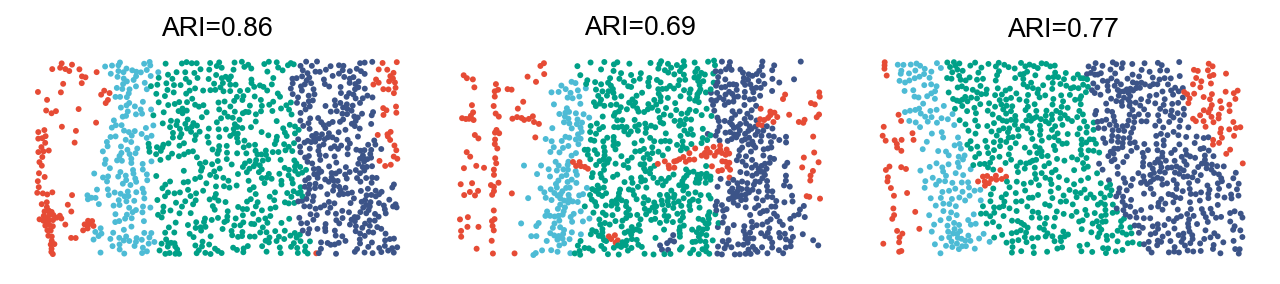

In [248]:
ARI_list = []
for bb in range(3):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))
    Batch_list[bb].uns['GPCA_pred_colors'] = Ref_colors
    
fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)

plt.show()

In [249]:
fig.savefig("../../results/STARmap/figure/Multi_GPCA.pdf")

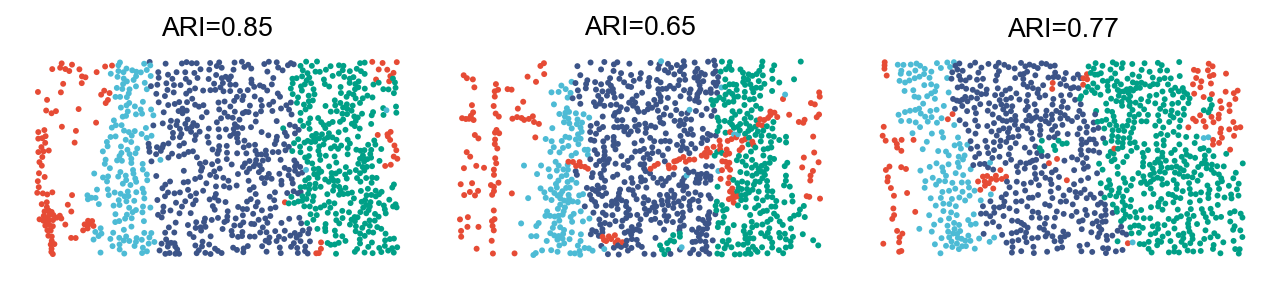

In [251]:
slice_names = ["BZ5","BZ9","BZ14"]
ARI_list = []
Ref_colors = ["#4DBBD5FF","#00A087FF","#3C5488FF","#E64B35FF"] ## BASS is started at 1
for bb in range(3):
    Batch_list[bb].obs["BASS_pred"] = pd.read_csv("../../results/STARmap/BASS_" + slice_names[bb] + "_pred.csv",index_col=0).BASS_pred.values
    Batch_list[bb].obs["BASS_pred"] = Batch_list[bb].obs["BASS_pred"].astype("category")
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['BASS_pred']), 2))
    Batch_list[bb].uns['BASS_pred_colors'] = Ref_colors
    
fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['BASS_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['BASS_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['BASS_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)

plt.show()



In [252]:
fig.savefig("../../results/STARmap/figure/Multi_BASS.pdf")

In [255]:
STAligner_data = sc.read("../../results/STARmap/Multi_STAligner.h5ad")

In [258]:

for i in range(3):
    Batch_list[i].obs["STAligner_pred"] = STAligner_data[STAligner_data.obs['batch_name'] == slice_names[i]].obs["mclust"]

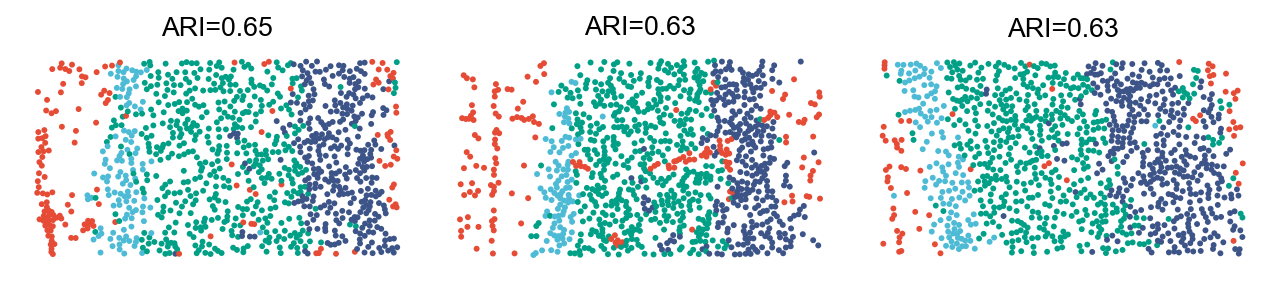

In [261]:
ARI_list = []
for bb in range(3):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['STAligner_pred']), 2))
    Batch_list[bb].uns['STAligner_pred_colors'] = Ref_colors
    
fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['STAligner_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['STAligner_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['STAligner_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)

plt.show()

In [262]:
fig.savefig("../../results/STARmap/figure/Multi_STAligner.pdf")

In [264]:
adata_concat = ad.concat(Batch_list, label="slice_name", keys=slice_names)
adata_concat.obs['groundtruth'] = adata_concat.obs['groundtruth'].astype('category')
adata_concat.obs["batch_name"] = adata_concat.obs["slice_name"].astype('category')
print('adata_concat.shape: ', adata_concat.shape)

adata_concat.shape:  (3190, 159)


In [265]:
print(ari_score(adata_concat.obs.STAligner_pred,adata_concat.obs.groundtruth))

0.6346897222425596


In [266]:
print(ari_score(adata_concat.obs.BASS_pred,adata_concat.obs.groundtruth))

0.7528498386538441


In [267]:
print(ari_score(adata_concat.obs.GPCA_pred,adata_concat.obs.groundtruth))

0.768871486169926


In [268]:
adata_concat.write_h5ad("../../results/STARmap/Multi_All.h5ad")

## Single sample analysis

In [386]:
slice_inds = np.arange(0,3)
samples = ["BZ5","BZ9","BZ14"]

In [387]:
Batch_list = []
adj_list = []


for sample_id in slice_inds:
    print(samples[sample_id])
    
    STARmap_expr = pd.read_csv("../../data/STARmap/STARmap_expr_" + samples[sample_id] + ".csv",index_col=0).T
    STARmap_loc = pd.read_csv("../../data/STARmap/STARmap_loc_" + samples[sample_id] + ".csv",index_col=0)
    groundTruth = pd.read_csv("../../data/STARmap/STARmap_groundtruth_" + samples[sample_id] + ".csv",index_col=0)["z"].astype("category")
    adata = ad.AnnData(STARmap_expr)
    adata.obs = STARmap_loc.copy()
    adata.uns["spatial"] = np.array(STARmap_loc)

    adata.obs["groundtruth"] =np.array(groundTruth)-1
    adata.obs["groundtruth"] = adata.obs["groundtruth"].astype(int).astype("category")

    adata.var_names_make_unique()  
    
    # make spot name unique
    adata.obs_names = [x+'_'+ samples[sample_id] for x in adata.obs_names]

    
    ## Constructing the spatial network
    x_array=adata.obs["x"].tolist()
    y_array=adata.obs["y"].tolist()
    X=np.array([x_array, y_array]).T.astype(np.float32)
    n_neighbors = 7
    graph = kneighbors_graph(np.asarray(X), int(n_neighbors), metric='euclidean',
                                     metric_params={}, include_self=False)
    graph = 0.5 * (graph + graph.T)

    adata.uns["adj"] = graph
    adata.obsm["spatial"] = X
    
    # Normalization
    sc.pp.filter_genes(adata, min_cells=20)
    sc.experimental.pp.normalize_pearson_residuals(adata)
    sc.pp.scale(adata)

    adj_list.append(adata.uns['adj'])
    Batch_list.append(adata)

BZ5
computing analytic Pearson residuals on adata.X
    finished (0:00:00)
BZ9
filtered out 7 genes that are detected in less than 20 cells
computing analytic Pearson residuals on adata.X
    finished (0:00:00)
BZ14
filtered out 2 genes that are detected in less than 20 cells
computing analytic Pearson residuals on adata.X
    finished (0:00:00)


In [388]:
Batch_list

[AnnData object with n_obs × n_vars = 1049 × 166
     obs: 'x', 'y', 'groundtruth'
     var: 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 1053 × 159
     obs: 'x', 'y', 'groundtruth'
     var: 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 1088 × 164
     obs: 'x', 'y', 'groundtruth'
     var: 'n_cells', 'mean', 'std'
     uns: 'spatial', 'adj', 'pearson_residuals_normalization'
     obsm: 'spatial']

In [396]:
for i in range(3):
    Z = Run_GPCA(Batch_list[i], network=None,location=Batch_list[i].obsm["spatial"], n_components = 50, method = "knn", n_neighbors = 7, _lambda = 0.6)
    estimator = KMeans(n_clusters=4,random_state=1118)
    res = estimator.fit(Z[:,:])
    lable_pred=res.labels_
    Batch_list[i].obs["GPCA_pred"]= lable_pred
    Batch_list[i].obs["GPCA_pred"] = Batch_list[i].obs["GPCA_pred"].astype('category')
    Batch_list[i].obsm["GraphPCA"] = Z
    
    refined_pred=refine(sample_id=Batch_list[i].obs.index.tolist(), pred=Batch_list[i].obs["GPCA_pred"].tolist(),
                        dis= pair(Batch_list[i].obsm["spatial"]), shape="generic",neighbor_num=7)
    Batch_list[i].obs["GPCA_pred"] = refined_pred
    Batch_list[i].obs["GPCA_pred"] = Batch_list[i].obs["GPCA_pred"].astype('category')
    Batch_list[i].obs['GPCA_pred'] = pd.Series(match_cluster_labels(Batch_list[i].obs['groundtruth'], Batch_list[i].obs['GPCA_pred'].values),
                                         index=Batch_list[i].obs.index, dtype='category')
    del Batch_list[i].uns["spatial"]
    print(ari_score(Batch_list[i].obs.GPCA_pred,Batch_list[i].obs.groundtruth))

0.8599895076677826
0.4356758301837097
0.8597972188426853


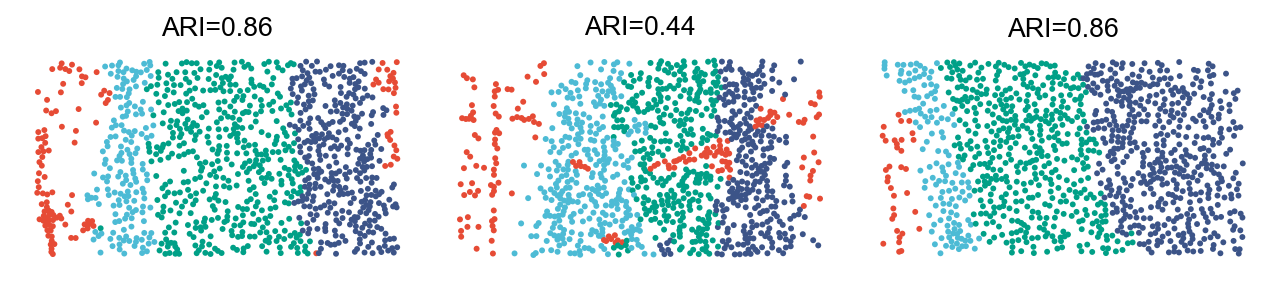

In [398]:
ARI_list = []
for bb in range(3):
    ARI_list.append(round(ari_score(Batch_list[bb].obs['groundtruth'], Batch_list[bb].obs['GPCA_pred']), 2))
    Batch_list[bb].uns['GPCA_pred_colors'] = Ref_colors
    
fig, ax = plt.subplots(1, 3, figsize=(10, 5), gridspec_kw={'wspace': 0.05, 'hspace': 0.1})
_sc_0 = sc.pl.spatial(Batch_list[0], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[0], frameon=False,
                      spot_size=spot_size)
_sc_0[0].set_title("ARI=" + str(ARI_list[0]), size=title_size)
_sc_1 = sc.pl.spatial(Batch_list[1], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[1], frameon=False,
                      spot_size=spot_size)
_sc_1[0].set_title("ARI=" + str(ARI_list[1]), size=title_size)
_sc_2 = sc.pl.spatial(Batch_list[2], img_key=None, color=['GPCA_pred'], title=[''],
                      legend_loc=None, legend_fontsize=12, show=False, ax=ax[2], frameon=False,
                      spot_size=spot_size)
_sc_2[0].set_title("ARI=" + str(ARI_list[2]), size=title_size)

plt.show()

In [399]:
fig.savefig("../../results/STARmap/figure/Single_GPCA.pdf")